# 正則化

加入正規項（Regularization term）後的損失函數變為：

$$L(x;\pmb w) = \frac{1}{2m} \sum_{i=1}^{m} {\| \pmb x^{(i)}\pmb w - \pmb y^{(i)} \|}^2 +\lambda \|\pmb w^2 \| \tag{3-28}$$

其中：

$$\|\pmb w^2 \| = {w_0}^2+  {w_1}^2 +\cdots+ {w_n}^2$$

新的損失函數梯度（Gradient）變為：

$$\nabla L(\pmb w ) = \frac{1}{m} \sum_{i=1}^{m} ( \pmb x^{(i)}\pmb w - \pmb y^{(i)}) x^{(i)}+ 2\lambda \pmb w \tag{3-29}$$

因此，在使用梯度下降法（Gradient Descent）求偏微分時，只需要在計算時加上後方這一項的梯度即可。以下是加入懲罰項（Penalty term）版本的梯度下降法：

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

def gradient_descent_reg(X, y, reg, alpha, num_iters, gamma=0.8, epsilon=1e-8):
    w_history = []          # 紀錄迭代過程中的參數
    # 在特徵矩陣左側添加一行全為 1 的行向量，代表截距項 (bias)
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    num_features = X.shape[1]

    v = np.zeros_like(num_features) # 初始化動量項 (velocity)
    # w = np.zeros(num_features)      # 初始化權重參數
    w = np.random.randn(num_features) * 0.01

    for n in range(num_iters):
        predictions = X @ w                 # 計算假設函數的預測值，即 f(x)
        errors = predictions - y            # 計算預測值與真實值之間的誤差

        # 計算基礎梯度
        gradient = X.transpose() @ errors / len(y)

        # 加入正規化項的梯度 (L2 Regularization)
        gradient += 2 * reg * w

        # 檢查梯度是否已經足夠小（收斂條件）
        if np.max(np.abs(gradient)) < epsilon:
            print("梯度已足夠小，停止迭代！")
            print("總迭代次數為：", n)
            break

        # 使用帶有動量的更新公式 (Momentum Update)
        # v 代表累積的動量，gamma 為衰減係數
        v = gamma * v + alpha * gradient
        w = w - v

        w_history.append(w)

    return w_history  # 回傳優化後的參數歷史紀錄

def loss_reg(w, X, y, reg=0.):
    """
    計算帶有正規化項的單次損失值
    """
    # X@w[1:] + w[0] 是將偏置項 (bias) w[0] 與權重項 w[1:] 分開計算
    errors = X @ w[1:] + w[0] - y

    # 計算正規化懲罰項 (Penalty term)，這裡 w 包含 bias，實務上通常只對權重做正規化
    reg_error = reg * np.sum(np.square(w))

    # 回傳 均方誤差 (MSE) 的一半加上正規化誤差
    return (errors**2).mean() / 2 + reg_error

def compute_loss_history_reg(X, y, w_history, reg=0.):
    """
    計算整個訓練過程中的損失函數歷史紀錄
    """
    loss_history = []
    for w in w_history:
        loss_history.append(loss_reg(w, X, y, reg))
    return loss_history

def plot_history_predict(X, y, w, loss_history, fig_size=(12, 4)):
    # 獲取當前的圖表對象
    fig = plt.gcf()
    # 設定圖表顯示的尺寸
    fig.set_size_inches(fig_size[0], fig_size[1], forward=True)

    # 繪製左側子圖：損失函數的收斂曲線
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title("Loss Convergence")

    # 在特徵矩陣左側添加一列全為 1 的向量，代表截距項 (bias)
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
    # 提取第一個特徵維度作為 x 軸（假設為簡單線性回歸或視覺化主要特徵）
    x = X[:, 1]

    # 計算模型的預測值
    predicts = X @ w

    # 繪製右側子圖：預測結果與原始資料散佈圖
    plt.subplot(1, 2, 2)
    plt.scatter(x, predicts) # 繪製預測點的散佈圖

    # 將 x 座標由大到小排序，確保繪製摺線圖時不會出現亂序的線條
    indices = x.argsort()
    sorted_x = x[indices[::-1]]
    sorted_predicts = predicts[indices[::-1]]

    # 繪製擬合後的紅色回歸線
    plt.plot(sorted_x, sorted_predicts, color = 'red')

    # 繪製原始資料的散佈圖，用來對比模型擬合效果
    plt.scatter(x, y)
    plt.title("Prediction vs Reality")
    plt.show()

梯度已足夠小，停止迭代！
總迭代次數為： 701
最終權重 w: [8.0125638  5.68328515 3.2896336  3.35876796 2.04969124 1.97134867
 1.30543839 1.14837098 0.83668811 0.65902045]


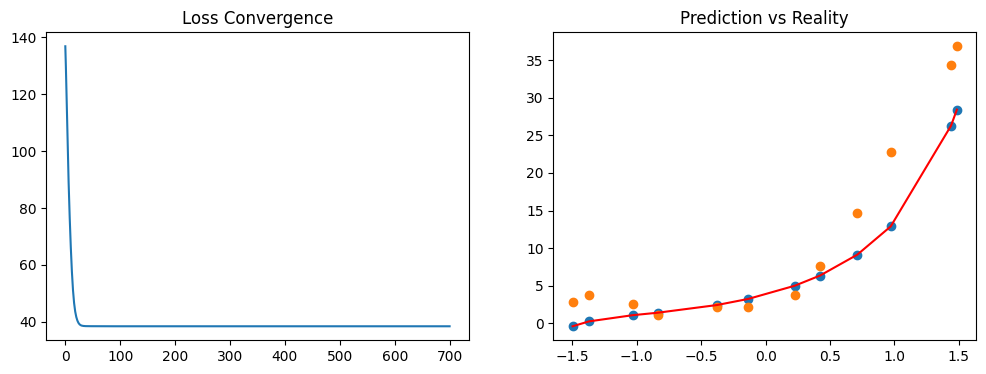

In [39]:
# 讀取 .mat 格式的資料集（通常用於 Andrew Ng 的機器學習課程資料）
dataset = sio.loadmat("/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/water.mat")
x_train = dataset["X"]
x_val = dataset["Xval"]
x_test = dataset["Xtest"]

# 將目標變量 y 壓縮成一維陣列，方便後續向量化運算
y_train = dataset["y"].squeeze()
y_val = dataset["yval"].squeeze()
y_test = dataset["ytest"].squeeze()

reg = 0.2              # 正規化參數 (lambda)，用來控制處罰項的強度
iterations = 100000    # 迭代次數
alpha = 0.01           # 學習率 (Learning Rate)，通常需要視情況調整
k = 9

x_train_n  = np.hstack(tuple(x_train ** (i+1) for i in range(k)))
mean = np.mean(x_train_n, axis=0)
stddev = np.std(x_train_n, axis=0)
x_train_n = (x_train_n - mean) / stddev

# 執行帶有正規化的梯度下降演算法
history = gradient_descent_reg(x_train_n, y_train, reg, alpha, iterations)

# 印出訓練完成後的最終權重參數
print("最終權重 w:", history[-1])

# 計算整個訓練過程中的損失函數歷史紀錄
loss_history = compute_loss_history_reg(x_train_n, y_train, history, reg)

# 繪製損失函數收斂曲線與模型預測結果
plot_history_predict(x_train_n, y_train, history[-1], loss_history)

In [40]:
def learning_curves(X_train, y_train, X_val, y_val, reg, alpha=0.3, iterations=1000):
    # 初始化訓練誤差與驗證誤差的陣列，長度與訓練樣本數相同
    train_err = np.zeros(len(y_train))
    val_err = np.zeros(len(y_train))

    # 透過循環增加訓練樣本數量，觀察模型在不同資料量下的表現
    for i in range(1, len(y_train)):
        # 使用前 i+1 個樣本進行訓練，獲取權重歷史
        w_history = gradient_descent_reg(X_train[0:i + 1, :], y_train[0:i + 1], reg, alpha, iterations)
        # 取得最後一次迭代優化後的權重
        w = w_history[-1]

        # 計算當前樣本規模下的訓練誤差（Training Error）
        train_err[i] = loss_reg(w, X_train[0:i + 1, :], y_train[0:i + 1], reg)
        # 計算在完整驗證集上的驗證誤差（Validation Error）
        val_err[i] = loss_reg(w, X_val, y_val, reg)

    # 繪製訓練誤差曲線（紅色）
    plt.plot(range(2, len(y_train) + 1), train_err[1:], c="r", linewidth=2)
    # 繪製驗證誤差曲線（藍色）
    plt.plot(range(2, len(y_train) + 1), val_err[1:], c="b", linewidth=2)

    # 設定圖表標籤與圖例
    plt.xlabel("number of training examples", fontsize=14) # 訓練樣本數量
    plt.ylabel("error", fontsize=14)                      # 誤差值
    plt.legend(["training", "validation"], loc="best")    # 圖例：訓練集與驗證集

    # 設定圖表範圍與網格
    plt.axis([2, len(y_train), 0, 100])
    plt.grid()

(12, 9)
(10,)
(21, 9)
梯度已足夠小，停止迭代！
總迭代次數為： 609
梯度已足夠小，停止迭代！
總迭代次數為： 610
梯度已足夠小，停止迭代！
總迭代次數為： 628
梯度已足夠小，停止迭代！
總迭代次數為： 642
梯度已足夠小，停止迭代！
總迭代次數為： 624
梯度已足夠小，停止迭代！
總迭代次數為： 693
梯度已足夠小，停止迭代！
總迭代次數為： 696
梯度已足夠小，停止迭代！
總迭代次數為： 696
梯度已足夠小，停止迭代！
總迭代次數為： 697
梯度已足夠小，停止迭代！
總迭代次數為： 690
梯度已足夠小，停止迭代！
總迭代次數為： 700


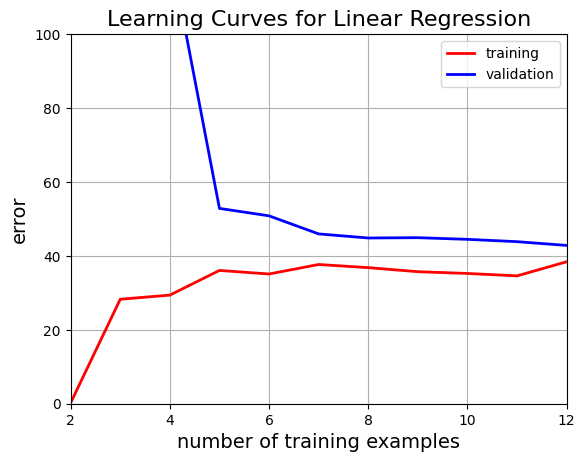

In [41]:
# 對驗證集進行多項式特徵擴展，產生 x, x^2, ..., x^n 的特徵矩陣
x_val_n  = np.hstack(tuple(x_val**(i+1) for i in range(k)))

# 使用訓練集的均值 (mean) 與標準差 (standard deviation) 對驗證集進行標準化（Scaling）
# 這是為了確保驗證集與訓練集處於相同的數值分佈空間
mean = np.mean(x_val_n, axis=0)
stddev = np.std(x_val_n, axis=0)
x_val_n = (x_val_n - mean) / stddev

# 設定圖表標題：線性回歸的學習曲線
plt.title("Learning Curves for Linear Regression", fontsize=16)

# 印出訓練集、權重與驗證集的維度 (Shape)，用於除錯與確認矩陣運算一致性
print(x_train_n.shape)
print(history[-1].shape)
print(x_val_n.shape)

# 設定正規化參數 lambda 為 0.2
reg = 0.2

# 呼叫 learning_curves 函式，開始繪製訓練誤差與驗證誤差隨樣本數增加的變化圖
learning_curves(x_train_n, y_train, x_val_n, y_val, reg, alpha, iterations)